# 19-13. 프로젝트 : Segmentation map으로 도로 이미지 만들기

---

- 아래 사이트를 참고하여 Segmentation map을 이용하여 도로 이미지를 만들어봅시다.
- 참고 사이트: [Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)

---

## 1. 데이터 준비하기

In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

from tensorflow import data

from tensorflow.keras import layers, Input, Model

from tensorflow.keras import losses
from tensorflow.keras import optimizers

In [2]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


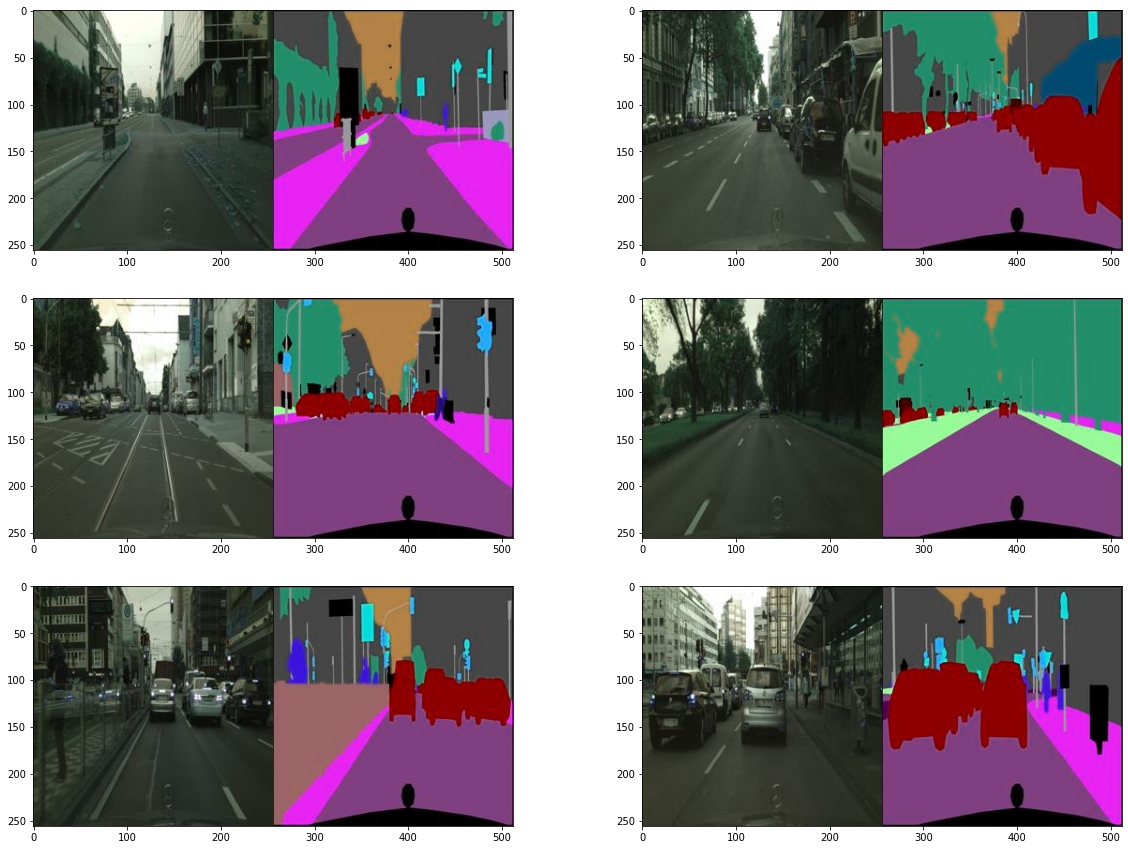

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


- 이미지를 확인해 봤을 때 실제 도로이미지와 색칠된 도로이미지가 하나의 이미지로 되어 있습니다.
- 이미지 크기는 (256, 512, 3)입니다.
- 이미지를 사용하기 위해 하나의 이미지를 2개로 나눠서 저장해줍니다.

In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    predicted = img[:, :w, :] 
    predicted = tf.cast(predicted, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(colored), normalize(predicted)

Text(0.5, 1.0, 'Ground Truth')

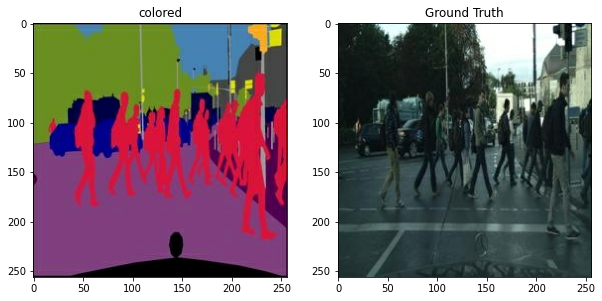

In [24]:
f = data_path + os.listdir(data_path)[1]
colored, predicted = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(colored)); plt.title('colored')
plt.subplot(1,2,2); plt.imshow(denormalize(predicted)); plt.title('Ground Truth')

- 위 사진처럼 색칠된 이미지(colored)와 색칠 이미지를 토대로 찾아낼 타겟 이미지(Predicted Image)로 나눕니다.
- 추가로 1000개의 데이터를 `apply_augmentation`를 이용하여 다양성을 높입니다.

In [7]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


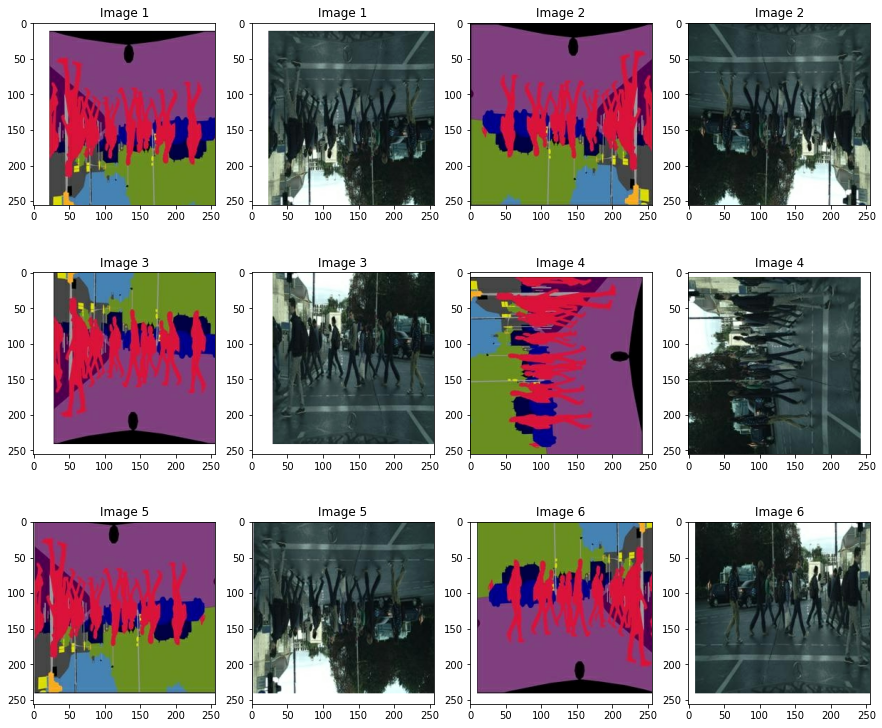

In [8]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_colored, augmented_predicted = apply_augmentation(colored, predicted)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_predicted)); plt.title(f"Image {img_n}")
    img_n += 1

- 다양한 이미지가 생성된 것을 확인했으며, `get_train`을 통해 학습데이터에 적용합니다.

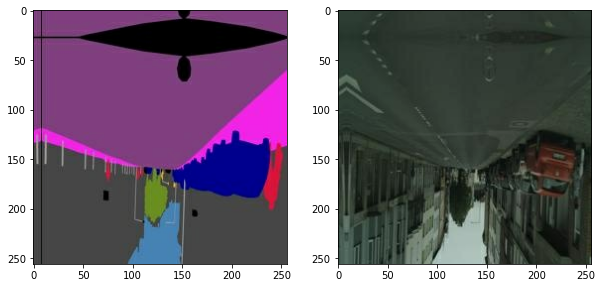

In [9]:
def get_train(img_path):
    colored, predicted = load_img(img_path)
    colored, predicted = apply_augmentation(colored, predicted)
    return colored, predicted

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
colored, predicted = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(colored[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(predicted[0].astype(np.uint8))

- 위 예시와 같이 뒤집혀진 이미지가 생성된 것을 확인할 수 있다.

## 2. Generator 구성하기

In [10]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [11]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [12]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## 3. Discriminator 구성하기

In [13]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [14]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [15]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [16]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

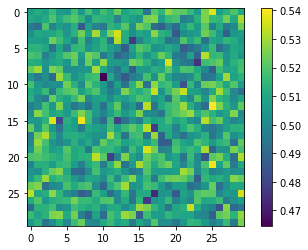

In [17]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 4. 학습 및 테스트하기

In [18]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [19]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [20]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


- 학습하기

In [21]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (colored, predicted) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(colored, predicted)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8294                     
L1_loss:0.3670                     
Discriminator_loss:1.3894

EPOCH[1] - STEP[20]                     
Generator_loss:0.9741                     
L1_loss:0.2678                     
Discriminator_loss:1.2582

EPOCH[1] - STEP[30]                     
Generator_loss:1.0766                     
L1_loss:0.2412                     
Discriminator_loss:1.5410

EPOCH[1] - STEP[40]                     
Generator_loss:0.8291                     
L1_loss:0.2258                     
Discriminator_loss:1.2444

EPOCH[1] - STEP[50]                     
Generator_loss:1.1060                     
L1_loss:0.2104                     
Discriminator_loss:1.3840

EPOCH[1] - STEP[60]                     
Generator_loss:1.0686                     
L1_loss:0.1781                     
Discriminator_loss:1.0904

EPOCH[1] - STEP[70]                     
Generator_loss:0.9168                     
L1_loss:0.1590                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.4996                     
L1_loss:0.1893                     
Discriminator_loss:0.5538

EPOCH[3] - STEP[80]                     
Generator_loss:1.1500                     
L1_loss:0.1636                     
Discriminator_loss:0.8879

EPOCH[3] - STEP[90]                     
Generator_loss:1.2488                     
L1_loss:0.1559                     
Discriminator_loss:0.6779

EPOCH[3] - STEP[100]                     
Generator_loss:1.4358                     
L1_loss:0.2101                     
Discriminator_loss:0.4394

EPOCH[3] - STEP[110]                     
Generator_loss:1.1781                     
L1_loss:0.1831                     
Discriminator_loss:1.1546

EPOCH[3] - STEP[120]                     
Generator_loss:0.4904                     
L1_loss:0.1699                     
Discriminator_loss:1.3638

EPOCH[3] - STEP[130]                     
Generator_loss:0.4268                     
L1_loss:0.1758                

EPOCH[5] - STEP[130]                     
Generator_loss:1.9951                     
L1_loss:0.1872                     
Discriminator_loss:0.3784

EPOCH[5] - STEP[140]                     
Generator_loss:1.0901                     
L1_loss:0.1787                     
Discriminator_loss:1.2214

EPOCH[5] - STEP[150]                     
Generator_loss:0.7563                     
L1_loss:0.1850                     
Discriminator_loss:0.9926

EPOCH[5] - STEP[160]                     
Generator_loss:1.3436                     
L1_loss:0.1769                     
Discriminator_loss:0.4571

EPOCH[5] - STEP[170]                     
Generator_loss:1.2455                     
L1_loss:0.1862                     
Discriminator_loss:0.7426

EPOCH[5] - STEP[180]                     
Generator_loss:1.8639                     
L1_loss:0.1614                     
Discriminator_loss:0.3015

EPOCH[5] - STEP[190]                     
Generator_loss:1.2212                     
L1_loss:0.1757             

EPOCH[7] - STEP[190]                     
Generator_loss:1.2049                     
L1_loss:0.1641                     
Discriminator_loss:0.9379

EPOCH[7] - STEP[200]                     
Generator_loss:0.8056                     
L1_loss:0.1578                     
Discriminator_loss:0.7482

EPOCH[7] - STEP[210]                     
Generator_loss:2.1377                     
L1_loss:0.1835                     
Discriminator_loss:0.7249

EPOCH[7] - STEP[220]                     
Generator_loss:0.8116                     
L1_loss:0.1711                     
Discriminator_loss:1.1320

EPOCH[7] - STEP[230]                     
Generator_loss:1.5111                     
L1_loss:0.1383                     
Discriminator_loss:1.3629

EPOCH[7] - STEP[240]                     
Generator_loss:0.3428                     
L1_loss:0.1927                     
Discriminator_loss:1.8752

EPOCH[7] - STEP[250]                     
Generator_loss:1.2068                     
L1_loss:0.1857             

EPOCH[9] - STEP[250]                     
Generator_loss:2.6345                     
L1_loss:0.1615                     
Discriminator_loss:2.1349

EPOCH[10] - STEP[10]                     
Generator_loss:1.2655                     
L1_loss:0.2301                     
Discriminator_loss:0.5770

EPOCH[10] - STEP[20]                     
Generator_loss:1.9998                     
L1_loss:0.2265                     
Discriminator_loss:0.1929

EPOCH[10] - STEP[30]                     
Generator_loss:1.0718                     
L1_loss:0.1771                     
Discriminator_loss:0.8811

EPOCH[10] - STEP[40]                     
Generator_loss:1.5641                     
L1_loss:0.1790                     
Discriminator_loss:1.9944

EPOCH[10] - STEP[50]                     
Generator_loss:2.1248                     
L1_loss:0.2067                     
Discriminator_loss:0.3355

EPOCH[10] - STEP[60]                     
Generator_loss:0.9263                     
L1_loss:0.1655             

EPOCH[12] - STEP[60]                     
Generator_loss:1.9140                     
L1_loss:0.2147                     
Discriminator_loss:0.2510

EPOCH[12] - STEP[70]                     
Generator_loss:2.2825                     
L1_loss:0.1921                     
Discriminator_loss:0.3001

EPOCH[12] - STEP[80]                     
Generator_loss:0.7254                     
L1_loss:0.1862                     
Discriminator_loss:0.8914

EPOCH[12] - STEP[90]                     
Generator_loss:1.5882                     
L1_loss:0.2180                     
Discriminator_loss:0.2683

EPOCH[12] - STEP[100]                     
Generator_loss:1.6239                     
L1_loss:0.1891                     
Discriminator_loss:0.6385

EPOCH[12] - STEP[110]                     
Generator_loss:1.4561                     
L1_loss:0.1817                     
Discriminator_loss:1.4542

EPOCH[12] - STEP[120]                     
Generator_loss:0.4187                     
L1_loss:0.1793          

EPOCH[14] - STEP[120]                     
Generator_loss:1.4824                     
L1_loss:0.1466                     
Discriminator_loss:0.7986

EPOCH[14] - STEP[130]                     
Generator_loss:0.7416                     
L1_loss:0.1857                     
Discriminator_loss:0.8477

EPOCH[14] - STEP[140]                     
Generator_loss:0.5684                     
L1_loss:0.2272                     
Discriminator_loss:0.9590

EPOCH[14] - STEP[150]                     
Generator_loss:1.8319                     
L1_loss:0.2041                     
Discriminator_loss:0.4256

EPOCH[14] - STEP[160]                     
Generator_loss:1.9654                     
L1_loss:0.1605                     
Discriminator_loss:1.6916

EPOCH[14] - STEP[170]                     
Generator_loss:2.5365                     
L1_loss:0.1911                     
Discriminator_loss:0.2215

EPOCH[14] - STEP[180]                     
Generator_loss:0.6847                     
L1_loss:0.1914      

EPOCH[16] - STEP[180]                     
Generator_loss:2.0382                     
L1_loss:0.1930                     
Discriminator_loss:0.8755

EPOCH[16] - STEP[190]                     
Generator_loss:2.0829                     
L1_loss:0.1836                     
Discriminator_loss:1.2568

EPOCH[16] - STEP[200]                     
Generator_loss:1.3547                     
L1_loss:0.1944                     
Discriminator_loss:0.3849

EPOCH[16] - STEP[210]                     
Generator_loss:2.3415                     
L1_loss:0.1822                     
Discriminator_loss:0.4922

EPOCH[16] - STEP[220]                     
Generator_loss:1.1103                     
L1_loss:0.1528                     
Discriminator_loss:1.0558

EPOCH[16] - STEP[230]                     
Generator_loss:0.8854                     
L1_loss:0.1828                     
Discriminator_loss:0.6906

EPOCH[16] - STEP[240]                     
Generator_loss:1.2004                     
L1_loss:0.1675      

EPOCH[18] - STEP[240]                     
Generator_loss:1.6313                     
L1_loss:0.1842                     
Discriminator_loss:0.6006

EPOCH[18] - STEP[250]                     
Generator_loss:2.2376                     
L1_loss:0.1843                     
Discriminator_loss:0.6739

EPOCH[19] - STEP[10]                     
Generator_loss:0.8285                     
L1_loss:0.1470                     
Discriminator_loss:1.4733

EPOCH[19] - STEP[20]                     
Generator_loss:1.5882                     
L1_loss:0.1639                     
Discriminator_loss:0.7332

EPOCH[19] - STEP[30]                     
Generator_loss:0.7501                     
L1_loss:0.1771                     
Discriminator_loss:1.1326

EPOCH[19] - STEP[40]                     
Generator_loss:1.1466                     
L1_loss:0.1619                     
Discriminator_loss:0.7568

EPOCH[19] - STEP[50]                     
Generator_loss:1.3950                     
L1_loss:0.2193           

EPOCH[21] - STEP[50]                     
Generator_loss:0.8068                     
L1_loss:0.1817                     
Discriminator_loss:0.8336

EPOCH[21] - STEP[60]                     
Generator_loss:1.4990                     
L1_loss:0.1685                     
Discriminator_loss:0.5944

EPOCH[21] - STEP[70]                     
Generator_loss:1.7759                     
L1_loss:0.1850                     
Discriminator_loss:0.3267

EPOCH[21] - STEP[80]                     
Generator_loss:2.4905                     
L1_loss:0.1560                     
Discriminator_loss:1.5833

EPOCH[21] - STEP[90]                     
Generator_loss:1.2962                     
L1_loss:0.1406                     
Discriminator_loss:1.6517

EPOCH[21] - STEP[100]                     
Generator_loss:1.4608                     
L1_loss:0.1554                     
Discriminator_loss:1.1829

EPOCH[21] - STEP[110]                     
Generator_loss:1.8022                     
L1_loss:0.1779           

EPOCH[23] - STEP[110]                     
Generator_loss:0.7670                     
L1_loss:0.1915                     
Discriminator_loss:0.8149

EPOCH[23] - STEP[120]                     
Generator_loss:1.4606                     
L1_loss:0.1548                     
Discriminator_loss:2.5091

EPOCH[23] - STEP[130]                     
Generator_loss:0.6573                     
L1_loss:0.1998                     
Discriminator_loss:0.8620

EPOCH[23] - STEP[140]                     
Generator_loss:1.2314                     
L1_loss:0.1399                     
Discriminator_loss:0.7284

EPOCH[23] - STEP[150]                     
Generator_loss:0.3943                     
L1_loss:0.1872                     
Discriminator_loss:1.2848

EPOCH[23] - STEP[160]                     
Generator_loss:1.2294                     
L1_loss:0.1469                     
Discriminator_loss:1.2032

EPOCH[23] - STEP[170]                     
Generator_loss:1.3378                     
L1_loss:0.1764      

EPOCH[25] - STEP[170]                     
Generator_loss:1.6149                     
L1_loss:0.1756                     
Discriminator_loss:0.9527

EPOCH[25] - STEP[180]                     
Generator_loss:1.6819                     
L1_loss:0.1941                     
Discriminator_loss:0.2808

EPOCH[25] - STEP[190]                     
Generator_loss:0.2052                     
L1_loss:0.1738                     
Discriminator_loss:2.2055

EPOCH[25] - STEP[200]                     
Generator_loss:0.8123                     
L1_loss:0.1798                     
Discriminator_loss:0.7406

EPOCH[25] - STEP[210]                     
Generator_loss:1.3814                     
L1_loss:0.2237                     
Discriminator_loss:0.3830

EPOCH[25] - STEP[220]                     
Generator_loss:2.1950                     
L1_loss:0.1526                     
Discriminator_loss:1.8356

EPOCH[25] - STEP[230]                     
Generator_loss:0.7569                     
L1_loss:0.1509      

EPOCH[27] - STEP[230]                     
Generator_loss:0.9960                     
L1_loss:0.1493                     
Discriminator_loss:1.1544

EPOCH[27] - STEP[240]                     
Generator_loss:1.0300                     
L1_loss:0.1818                     
Discriminator_loss:0.6521

EPOCH[27] - STEP[250]                     
Generator_loss:1.0991                     
L1_loss:0.1749                     
Discriminator_loss:1.1235

EPOCH[28] - STEP[10]                     
Generator_loss:2.6724                     
L1_loss:0.2018                     
Discriminator_loss:0.3694

EPOCH[28] - STEP[20]                     
Generator_loss:1.7341                     
L1_loss:0.1755                     
Discriminator_loss:0.6787

EPOCH[28] - STEP[30]                     
Generator_loss:1.6337                     
L1_loss:0.2159                     
Discriminator_loss:0.3222

EPOCH[28] - STEP[40]                     
Generator_loss:2.3586                     
L1_loss:0.1764          

EPOCH[30] - STEP[40]                     
Generator_loss:1.7912                     
L1_loss:0.2008                     
Discriminator_loss:0.2531

EPOCH[30] - STEP[50]                     
Generator_loss:2.1195                     
L1_loss:0.1868                     
Discriminator_loss:0.4611

EPOCH[30] - STEP[60]                     
Generator_loss:0.8870                     
L1_loss:0.1863                     
Discriminator_loss:0.8146

EPOCH[30] - STEP[70]                     
Generator_loss:1.3390                     
L1_loss:0.1543                     
Discriminator_loss:0.7541

EPOCH[30] - STEP[80]                     
Generator_loss:2.2276                     
L1_loss:0.2225                     
Discriminator_loss:0.7245

EPOCH[30] - STEP[90]                     
Generator_loss:1.6484                     
L1_loss:0.1624                     
Discriminator_loss:0.8596

EPOCH[30] - STEP[100]                     
Generator_loss:0.2558                     
L1_loss:0.1557            

EPOCH[32] - STEP[100]                     
Generator_loss:1.2636                     
L1_loss:0.1808                     
Discriminator_loss:0.7642

EPOCH[32] - STEP[110]                     
Generator_loss:0.9392                     
L1_loss:0.1905                     
Discriminator_loss:0.7498

EPOCH[32] - STEP[120]                     
Generator_loss:1.3723                     
L1_loss:0.2518                     
Discriminator_loss:0.4076

EPOCH[32] - STEP[130]                     
Generator_loss:1.9234                     
L1_loss:0.1700                     
Discriminator_loss:1.1497

EPOCH[32] - STEP[140]                     
Generator_loss:2.0741                     
L1_loss:0.1608                     
Discriminator_loss:0.4784

EPOCH[32] - STEP[150]                     
Generator_loss:0.9359                     
L1_loss:0.1807                     
Discriminator_loss:1.4982

EPOCH[32] - STEP[160]                     
Generator_loss:1.0958                     
L1_loss:0.1547      

EPOCH[34] - STEP[160]                     
Generator_loss:2.2442                     
L1_loss:0.1612                     
Discriminator_loss:0.3548

EPOCH[34] - STEP[170]                     
Generator_loss:2.1172                     
L1_loss:0.1814                     
Discriminator_loss:0.3315

EPOCH[34] - STEP[180]                     
Generator_loss:1.2851                     
L1_loss:0.1466                     
Discriminator_loss:0.9410

EPOCH[34] - STEP[190]                     
Generator_loss:2.5435                     
L1_loss:0.1572                     
Discriminator_loss:0.8289

EPOCH[34] - STEP[200]                     
Generator_loss:1.8363                     
L1_loss:0.2085                     
Discriminator_loss:0.3311

EPOCH[34] - STEP[210]                     
Generator_loss:1.9302                     
L1_loss:0.1371                     
Discriminator_loss:1.7222

EPOCH[34] - STEP[220]                     
Generator_loss:2.1108                     
L1_loss:0.1945      

EPOCH[36] - STEP[220]                     
Generator_loss:1.8487                     
L1_loss:0.1605                     
Discriminator_loss:0.8699

EPOCH[36] - STEP[230]                     
Generator_loss:0.8264                     
L1_loss:0.1693                     
Discriminator_loss:1.3222

EPOCH[36] - STEP[240]                     
Generator_loss:1.0238                     
L1_loss:0.1770                     
Discriminator_loss:0.6571

EPOCH[36] - STEP[250]                     
Generator_loss:1.4086                     
L1_loss:0.1679                     
Discriminator_loss:1.0359

EPOCH[37] - STEP[10]                     
Generator_loss:1.9505                     
L1_loss:0.1663                     
Discriminator_loss:1.0803

EPOCH[37] - STEP[20]                     
Generator_loss:1.4502                     
L1_loss:0.1554                     
Discriminator_loss:0.9313

EPOCH[37] - STEP[30]                     
Generator_loss:2.0020                     
L1_loss:0.1819         

EPOCH[39] - STEP[30]                     
Generator_loss:1.0204                     
L1_loss:0.1615                     
Discriminator_loss:1.1602

EPOCH[39] - STEP[40]                     
Generator_loss:1.0314                     
L1_loss:0.1568                     
Discriminator_loss:0.6364

EPOCH[39] - STEP[50]                     
Generator_loss:1.5248                     
L1_loss:0.2006                     
Discriminator_loss:0.3056

EPOCH[39] - STEP[60]                     
Generator_loss:1.1381                     
L1_loss:0.1681                     
Discriminator_loss:0.9551

EPOCH[39] - STEP[70]                     
Generator_loss:0.3568                     
L1_loss:0.1877                     
Discriminator_loss:1.3594

EPOCH[39] - STEP[80]                     
Generator_loss:0.7364                     
L1_loss:0.1787                     
Discriminator_loss:0.8865

EPOCH[39] - STEP[90]                     
Generator_loss:0.5926                     
L1_loss:0.1359             

EPOCH[41] - STEP[90]                     
Generator_loss:0.4773                     
L1_loss:0.1542                     
Discriminator_loss:1.3096

EPOCH[41] - STEP[100]                     
Generator_loss:2.4639                     
L1_loss:0.1846                     
Discriminator_loss:0.5342

EPOCH[41] - STEP[110]                     
Generator_loss:1.5368                     
L1_loss:0.1988                     
Discriminator_loss:0.3179

EPOCH[41] - STEP[120]                     
Generator_loss:1.2214                     
L1_loss:0.1606                     
Discriminator_loss:0.4778

EPOCH[41] - STEP[130]                     
Generator_loss:0.6577                     
L1_loss:0.1866                     
Discriminator_loss:1.0163

EPOCH[41] - STEP[140]                     
Generator_loss:1.4919                     
L1_loss:0.1385                     
Discriminator_loss:1.6579

EPOCH[41] - STEP[150]                     
Generator_loss:1.2095                     
L1_loss:0.1934       

EPOCH[43] - STEP[150]                     
Generator_loss:0.6582                     
L1_loss:0.1912                     
Discriminator_loss:0.8985

EPOCH[43] - STEP[160]                     
Generator_loss:1.1178                     
L1_loss:0.1713                     
Discriminator_loss:0.7617

EPOCH[43] - STEP[170]                     
Generator_loss:0.8507                     
L1_loss:0.2179                     
Discriminator_loss:0.7010

EPOCH[43] - STEP[180]                     
Generator_loss:1.5781                     
L1_loss:0.1522                     
Discriminator_loss:0.5703

EPOCH[43] - STEP[190]                     
Generator_loss:0.6455                     
L1_loss:0.2329                     
Discriminator_loss:1.2400

EPOCH[43] - STEP[200]                     
Generator_loss:1.2396                     
L1_loss:0.1519                     
Discriminator_loss:0.8079

EPOCH[43] - STEP[210]                     
Generator_loss:1.3825                     
L1_loss:0.1744      

EPOCH[45] - STEP[210]                     
Generator_loss:2.2034                     
L1_loss:0.1636                     
Discriminator_loss:3.3767

EPOCH[45] - STEP[220]                     
Generator_loss:2.4712                     
L1_loss:0.2134                     
Discriminator_loss:0.3737

EPOCH[45] - STEP[230]                     
Generator_loss:2.0140                     
L1_loss:0.2114                     
Discriminator_loss:0.2809

EPOCH[45] - STEP[240]                     
Generator_loss:1.0751                     
L1_loss:0.1910                     
Discriminator_loss:0.8766

EPOCH[45] - STEP[250]                     
Generator_loss:2.0533                     
L1_loss:0.1702                     
Discriminator_loss:0.6841

EPOCH[46] - STEP[10]                     
Generator_loss:2.0255                     
L1_loss:0.1778                     
Discriminator_loss:0.4299

EPOCH[46] - STEP[20]                     
Generator_loss:1.5081                     
L1_loss:0.1725        

EPOCH[48] - STEP[20]                     
Generator_loss:2.3517                     
L1_loss:0.1818                     
Discriminator_loss:0.7068

EPOCH[48] - STEP[30]                     
Generator_loss:1.4904                     
L1_loss:0.2037                     
Discriminator_loss:0.3144

EPOCH[48] - STEP[40]                     
Generator_loss:2.1675                     
L1_loss:0.1567                     
Discriminator_loss:2.0023

EPOCH[48] - STEP[50]                     
Generator_loss:1.3494                     
L1_loss:0.1730                     
Discriminator_loss:0.4146

EPOCH[48] - STEP[60]                     
Generator_loss:1.2103                     
L1_loss:0.1822                     
Discriminator_loss:0.6299

EPOCH[48] - STEP[70]                     
Generator_loss:1.4974                     
L1_loss:0.2035                     
Discriminator_loss:0.3693

EPOCH[48] - STEP[80]                     
Generator_loss:2.1634                     
L1_loss:0.1807             

EPOCH[50] - STEP[80]                     
Generator_loss:1.2614                     
L1_loss:0.1597                     
Discriminator_loss:0.8525

EPOCH[50] - STEP[90]                     
Generator_loss:3.0182                     
L1_loss:0.1777                     
Discriminator_loss:0.5193

EPOCH[50] - STEP[100]                     
Generator_loss:1.4672                     
L1_loss:0.1858                     
Discriminator_loss:0.3987

EPOCH[50] - STEP[110]                     
Generator_loss:2.0191                     
L1_loss:0.1713                     
Discriminator_loss:0.2378

EPOCH[50] - STEP[120]                     
Generator_loss:2.0258                     
L1_loss:0.1559                     
Discriminator_loss:1.8144

EPOCH[50] - STEP[130]                     
Generator_loss:1.8181                     
L1_loss:0.1534                     
Discriminator_loss:1.1918

EPOCH[50] - STEP[140]                     
Generator_loss:2.3602                     
L1_loss:0.1596        

EPOCH[52] - STEP[140]                     
Generator_loss:1.4549                     
L1_loss:0.1756                     
Discriminator_loss:0.3888

EPOCH[52] - STEP[150]                     
Generator_loss:1.2280                     
L1_loss:0.1657                     
Discriminator_loss:1.7031

EPOCH[52] - STEP[160]                     
Generator_loss:1.1497                     
L1_loss:0.1911                     
Discriminator_loss:0.5895

EPOCH[52] - STEP[170]                     
Generator_loss:0.8964                     
L1_loss:0.1714                     
Discriminator_loss:1.7360

EPOCH[52] - STEP[180]                     
Generator_loss:1.6689                     
L1_loss:0.1667                     
Discriminator_loss:0.5302

EPOCH[52] - STEP[190]                     
Generator_loss:1.6689                     
L1_loss:0.1679                     
Discriminator_loss:0.3805

EPOCH[52] - STEP[200]                     
Generator_loss:1.5393                     
L1_loss:0.1717      

EPOCH[54] - STEP[200]                     
Generator_loss:1.4671                     
L1_loss:0.1507                     
Discriminator_loss:1.0325

EPOCH[54] - STEP[210]                     
Generator_loss:0.7481                     
L1_loss:0.1853                     
Discriminator_loss:1.1034

EPOCH[54] - STEP[220]                     
Generator_loss:1.2584                     
L1_loss:0.1511                     
Discriminator_loss:1.1976

EPOCH[54] - STEP[230]                     
Generator_loss:3.3944                     
L1_loss:0.1716                     
Discriminator_loss:1.3585

EPOCH[54] - STEP[240]                     
Generator_loss:1.0371                     
L1_loss:0.1539                     
Discriminator_loss:1.2184

EPOCH[54] - STEP[250]                     
Generator_loss:2.1773                     
L1_loss:0.1689                     
Discriminator_loss:0.7618

EPOCH[55] - STEP[10]                     
Generator_loss:1.2788                     
L1_loss:0.1553       

EPOCH[57] - STEP[10]                     
Generator_loss:1.9294                     
L1_loss:0.1738                     
Discriminator_loss:1.2233

EPOCH[57] - STEP[20]                     
Generator_loss:2.6360                     
L1_loss:0.1615                     
Discriminator_loss:0.8054

EPOCH[57] - STEP[30]                     
Generator_loss:1.5082                     
L1_loss:0.1585                     
Discriminator_loss:1.6431

EPOCH[57] - STEP[40]                     
Generator_loss:2.7886                     
L1_loss:0.1768                     
Discriminator_loss:0.6043

EPOCH[57] - STEP[50]                     
Generator_loss:0.5367                     
L1_loss:0.2194                     
Discriminator_loss:1.0507

EPOCH[57] - STEP[60]                     
Generator_loss:1.2577                     
L1_loss:0.1781                     
Discriminator_loss:0.4458

EPOCH[57] - STEP[70]                     
Generator_loss:2.1766                     
L1_loss:0.1683             

EPOCH[59] - STEP[70]                     
Generator_loss:1.3018                     
L1_loss:0.1861                     
Discriminator_loss:1.7871

EPOCH[59] - STEP[80]                     
Generator_loss:1.5668                     
L1_loss:0.1439                     
Discriminator_loss:1.2236

EPOCH[59] - STEP[90]                     
Generator_loss:2.3041                     
L1_loss:0.1729                     
Discriminator_loss:2.0599

EPOCH[59] - STEP[100]                     
Generator_loss:1.6068                     
L1_loss:0.1446                     
Discriminator_loss:1.9232

EPOCH[59] - STEP[110]                     
Generator_loss:1.0009                     
L1_loss:0.1757                     
Discriminator_loss:1.1965

EPOCH[59] - STEP[120]                     
Generator_loss:0.6453                     
L1_loss:0.1671                     
Discriminator_loss:1.0808

EPOCH[59] - STEP[130]                     
Generator_loss:0.4078                     
L1_loss:0.1776         

EPOCH[61] - STEP[130]                     
Generator_loss:2.2614                     
L1_loss:0.1562                     
Discriminator_loss:0.6838

EPOCH[61] - STEP[140]                     
Generator_loss:1.0983                     
L1_loss:0.1746                     
Discriminator_loss:0.5611

EPOCH[61] - STEP[150]                     
Generator_loss:2.1553                     
L1_loss:0.1970                     
Discriminator_loss:0.1847

EPOCH[61] - STEP[160]                     
Generator_loss:1.6402                     
L1_loss:0.1872                     
Discriminator_loss:0.7307

EPOCH[61] - STEP[170]                     
Generator_loss:1.7682                     
L1_loss:0.1694                     
Discriminator_loss:2.2932

EPOCH[61] - STEP[180]                     
Generator_loss:1.3835                     
L1_loss:0.1994                     
Discriminator_loss:0.5242

EPOCH[61] - STEP[190]                     
Generator_loss:0.9059                     
L1_loss:0.1805      

EPOCH[63] - STEP[190]                     
Generator_loss:1.8357                     
L1_loss:0.1845                     
Discriminator_loss:0.6162

EPOCH[63] - STEP[200]                     
Generator_loss:2.2019                     
L1_loss:0.1668                     
Discriminator_loss:0.3896

EPOCH[63] - STEP[210]                     
Generator_loss:0.7071                     
L1_loss:0.2007                     
Discriminator_loss:0.8991

EPOCH[63] - STEP[220]                     
Generator_loss:1.3737                     
L1_loss:0.1795                     
Discriminator_loss:0.6084

EPOCH[63] - STEP[230]                     
Generator_loss:2.2590                     
L1_loss:0.1841                     
Discriminator_loss:0.3185

EPOCH[63] - STEP[240]                     
Generator_loss:1.8329                     
L1_loss:0.1818                     
Discriminator_loss:1.1229

EPOCH[63] - STEP[250]                     
Generator_loss:1.6807                     
L1_loss:0.1571      

EPOCH[65] - STEP[250]                     
Generator_loss:1.2165                     
L1_loss:0.1759                     
Discriminator_loss:0.7414

EPOCH[66] - STEP[10]                     
Generator_loss:0.9327                     
L1_loss:0.1842                     
Discriminator_loss:0.6968

EPOCH[66] - STEP[20]                     
Generator_loss:0.8762                     
L1_loss:0.1732                     
Discriminator_loss:0.7696

EPOCH[66] - STEP[30]                     
Generator_loss:1.4417                     
L1_loss:0.2272                     
Discriminator_loss:0.3417

EPOCH[66] - STEP[40]                     
Generator_loss:1.1568                     
L1_loss:0.1438                     
Discriminator_loss:1.0418

EPOCH[66] - STEP[50]                     
Generator_loss:2.6459                     
L1_loss:0.1596                     
Discriminator_loss:1.6184

EPOCH[66] - STEP[60]                     
Generator_loss:1.7800                     
L1_loss:0.1650            

EPOCH[68] - STEP[60]                     
Generator_loss:1.1384                     
L1_loss:0.1571                     
Discriminator_loss:1.2782

EPOCH[68] - STEP[70]                     
Generator_loss:1.3954                     
L1_loss:0.1664                     
Discriminator_loss:0.5012

EPOCH[68] - STEP[80]                     
Generator_loss:0.8892                     
L1_loss:0.1613                     
Discriminator_loss:0.7932

EPOCH[68] - STEP[90]                     
Generator_loss:2.2906                     
L1_loss:0.1450                     
Discriminator_loss:1.5637

EPOCH[68] - STEP[100]                     
Generator_loss:1.7530                     
L1_loss:0.1977                     
Discriminator_loss:0.2894

EPOCH[68] - STEP[110]                     
Generator_loss:2.3944                     
L1_loss:0.1725                     
Discriminator_loss:2.6827

EPOCH[68] - STEP[120]                     
Generator_loss:1.7880                     
L1_loss:0.1876          

EPOCH[70] - STEP[120]                     
Generator_loss:1.2608                     
L1_loss:0.1805                     
Discriminator_loss:0.6458

EPOCH[70] - STEP[130]                     
Generator_loss:1.6759                     
L1_loss:0.1593                     
Discriminator_loss:0.7003

EPOCH[70] - STEP[140]                     
Generator_loss:0.9450                     
L1_loss:0.1890                     
Discriminator_loss:0.6255

EPOCH[70] - STEP[150]                     
Generator_loss:0.5270                     
L1_loss:0.1523                     
Discriminator_loss:1.0794

EPOCH[70] - STEP[160]                     
Generator_loss:2.5274                     
L1_loss:0.1659                     
Discriminator_loss:0.3245

EPOCH[70] - STEP[170]                     
Generator_loss:1.8414                     
L1_loss:0.1644                     
Discriminator_loss:2.1493

EPOCH[70] - STEP[180]                     
Generator_loss:1.0783                     
L1_loss:0.2208      

EPOCH[72] - STEP[180]                     
Generator_loss:1.4449                     
L1_loss:0.1908                     
Discriminator_loss:0.9556

EPOCH[72] - STEP[190]                     
Generator_loss:0.3526                     
L1_loss:0.1815                     
Discriminator_loss:1.4967

EPOCH[72] - STEP[200]                     
Generator_loss:0.8659                     
L1_loss:0.1811                     
Discriminator_loss:1.6891

EPOCH[72] - STEP[210]                     
Generator_loss:1.5131                     
L1_loss:0.1640                     
Discriminator_loss:0.4500

EPOCH[72] - STEP[220]                     
Generator_loss:0.9145                     
L1_loss:0.1500                     
Discriminator_loss:0.6931

EPOCH[72] - STEP[230]                     
Generator_loss:1.2757                     
L1_loss:0.1912                     
Discriminator_loss:1.7721

EPOCH[72] - STEP[240]                     
Generator_loss:1.4512                     
L1_loss:0.1737      

EPOCH[74] - STEP[240]                     
Generator_loss:1.9893                     
L1_loss:0.1724                     
Discriminator_loss:0.9758

EPOCH[74] - STEP[250]                     
Generator_loss:1.7148                     
L1_loss:0.1849                     
Discriminator_loss:0.4894

EPOCH[75] - STEP[10]                     
Generator_loss:1.1889                     
L1_loss:0.1837                     
Discriminator_loss:0.5092

EPOCH[75] - STEP[20]                     
Generator_loss:1.1464                     
L1_loss:0.2062                     
Discriminator_loss:0.5191

EPOCH[75] - STEP[30]                     
Generator_loss:1.5821                     
L1_loss:0.1442                     
Discriminator_loss:0.8845

EPOCH[75] - STEP[40]                     
Generator_loss:1.5598                     
L1_loss:0.1591                     
Discriminator_loss:1.7402

EPOCH[75] - STEP[50]                     
Generator_loss:2.7122                     
L1_loss:0.1612           

EPOCH[77] - STEP[50]                     
Generator_loss:1.8301                     
L1_loss:0.1971                     
Discriminator_loss:1.3056

EPOCH[77] - STEP[60]                     
Generator_loss:1.7722                     
L1_loss:0.1882                     
Discriminator_loss:0.3076

EPOCH[77] - STEP[70]                     
Generator_loss:2.6254                     
L1_loss:0.1952                     
Discriminator_loss:0.1385

EPOCH[77] - STEP[80]                     
Generator_loss:1.8679                     
L1_loss:0.1743                     
Discriminator_loss:1.7709

EPOCH[77] - STEP[90]                     
Generator_loss:0.7300                     
L1_loss:0.2112                     
Discriminator_loss:0.8063

EPOCH[77] - STEP[100]                     
Generator_loss:2.0043                     
L1_loss:0.1882                     
Discriminator_loss:0.4295

EPOCH[77] - STEP[110]                     
Generator_loss:1.4724                     
L1_loss:0.1459           

EPOCH[79] - STEP[110]                     
Generator_loss:1.6457                     
L1_loss:0.1588                     
Discriminator_loss:1.4477

EPOCH[79] - STEP[120]                     
Generator_loss:1.3044                     
L1_loss:0.1745                     
Discriminator_loss:0.4961

EPOCH[79] - STEP[130]                     
Generator_loss:1.8185                     
L1_loss:0.1809                     
Discriminator_loss:0.8832

EPOCH[79] - STEP[140]                     
Generator_loss:1.7166                     
L1_loss:0.1997                     
Discriminator_loss:1.2787

EPOCH[79] - STEP[150]                     
Generator_loss:2.0643                     
L1_loss:0.2088                     
Discriminator_loss:0.3512

EPOCH[79] - STEP[160]                     
Generator_loss:0.6051                     
L1_loss:0.1732                     
Discriminator_loss:1.1736

EPOCH[79] - STEP[170]                     
Generator_loss:1.6793                     
L1_loss:0.1464      

EPOCH[81] - STEP[170]                     
Generator_loss:2.6756                     
L1_loss:0.1576                     
Discriminator_loss:2.0404

EPOCH[81] - STEP[180]                     
Generator_loss:1.3581                     
L1_loss:0.2019                     
Discriminator_loss:0.3640

EPOCH[81] - STEP[190]                     
Generator_loss:1.9122                     
L1_loss:0.1663                     
Discriminator_loss:1.0188

EPOCH[81] - STEP[200]                     
Generator_loss:1.3118                     
L1_loss:0.1727                     
Discriminator_loss:0.9341

EPOCH[81] - STEP[210]                     
Generator_loss:2.7889                     
L1_loss:0.1900                     
Discriminator_loss:0.9315

EPOCH[81] - STEP[220]                     
Generator_loss:0.8640                     
L1_loss:0.1728                     
Discriminator_loss:1.1621

EPOCH[81] - STEP[230]                     
Generator_loss:1.3799                     
L1_loss:0.1801      

EPOCH[83] - STEP[230]                     
Generator_loss:2.5686                     
L1_loss:0.1533                     
Discriminator_loss:0.7397

EPOCH[83] - STEP[240]                     
Generator_loss:1.3879                     
L1_loss:0.1880                     
Discriminator_loss:0.3839

EPOCH[83] - STEP[250]                     
Generator_loss:1.4167                     
L1_loss:0.1507                     
Discriminator_loss:0.9379

EPOCH[84] - STEP[10]                     
Generator_loss:2.0062                     
L1_loss:0.1648                     
Discriminator_loss:1.1748

EPOCH[84] - STEP[20]                     
Generator_loss:1.2610                     
L1_loss:0.1866                     
Discriminator_loss:0.8007

EPOCH[84] - STEP[30]                     
Generator_loss:1.8261                     
L1_loss:0.1484                     
Discriminator_loss:1.4020

EPOCH[84] - STEP[40]                     
Generator_loss:1.3849                     
L1_loss:0.1791          

EPOCH[86] - STEP[40]                     
Generator_loss:1.5891                     
L1_loss:0.1781                     
Discriminator_loss:2.0308

EPOCH[86] - STEP[50]                     
Generator_loss:0.5207                     
L1_loss:0.1656                     
Discriminator_loss:1.3917

EPOCH[86] - STEP[60]                     
Generator_loss:1.2960                     
L1_loss:0.1902                     
Discriminator_loss:0.4003

EPOCH[86] - STEP[70]                     
Generator_loss:2.0982                     
L1_loss:0.1590                     
Discriminator_loss:0.7476

EPOCH[86] - STEP[80]                     
Generator_loss:1.7826                     
L1_loss:0.1548                     
Discriminator_loss:1.8155

EPOCH[86] - STEP[90]                     
Generator_loss:1.7835                     
L1_loss:0.1561                     
Discriminator_loss:0.9474

EPOCH[86] - STEP[100]                     
Generator_loss:1.3404                     
L1_loss:0.1787            

EPOCH[88] - STEP[100]                     
Generator_loss:0.4649                     
L1_loss:0.1741                     
Discriminator_loss:1.3671

EPOCH[88] - STEP[110]                     
Generator_loss:1.1359                     
L1_loss:0.1752                     
Discriminator_loss:0.8021

EPOCH[88] - STEP[120]                     
Generator_loss:0.8441                     
L1_loss:0.1614                     
Discriminator_loss:1.0355

EPOCH[88] - STEP[130]                     
Generator_loss:0.7370                     
L1_loss:0.1731                     
Discriminator_loss:1.2911

EPOCH[88] - STEP[140]                     
Generator_loss:1.7209                     
L1_loss:0.1847                     
Discriminator_loss:0.2975

EPOCH[88] - STEP[150]                     
Generator_loss:1.8267                     
L1_loss:0.1593                     
Discriminator_loss:1.7082

EPOCH[88] - STEP[160]                     
Generator_loss:0.9770                     
L1_loss:0.1742      

EPOCH[90] - STEP[160]                     
Generator_loss:0.6763                     
L1_loss:0.1773                     
Discriminator_loss:1.6877

EPOCH[90] - STEP[170]                     
Generator_loss:1.6648                     
L1_loss:0.1957                     
Discriminator_loss:0.3030

EPOCH[90] - STEP[180]                     
Generator_loss:2.0517                     
L1_loss:0.1897                     
Discriminator_loss:0.5453

EPOCH[90] - STEP[190]                     
Generator_loss:0.7368                     
L1_loss:0.1685                     
Discriminator_loss:1.4292

EPOCH[90] - STEP[200]                     
Generator_loss:2.2180                     
L1_loss:0.1770                     
Discriminator_loss:0.3620

EPOCH[90] - STEP[210]                     
Generator_loss:0.4681                     
L1_loss:0.1811                     
Discriminator_loss:1.2818

EPOCH[90] - STEP[220]                     
Generator_loss:0.7762                     
L1_loss:0.1638      

EPOCH[92] - STEP[220]                     
Generator_loss:1.1286                     
L1_loss:0.1534                     
Discriminator_loss:1.4870

EPOCH[92] - STEP[230]                     
Generator_loss:1.8699                     
L1_loss:0.2007                     
Discriminator_loss:0.2650

EPOCH[92] - STEP[240]                     
Generator_loss:1.2783                     
L1_loss:0.1566                     
Discriminator_loss:0.9618

EPOCH[92] - STEP[250]                     
Generator_loss:1.0622                     
L1_loss:0.1690                     
Discriminator_loss:0.5249

EPOCH[93] - STEP[10]                     
Generator_loss:2.0183                     
L1_loss:0.1887                     
Discriminator_loss:0.7613

EPOCH[93] - STEP[20]                     
Generator_loss:1.6070                     
L1_loss:0.1850                     
Discriminator_loss:0.9236

EPOCH[93] - STEP[30]                     
Generator_loss:2.3271                     
L1_loss:0.1477         

EPOCH[95] - STEP[30]                     
Generator_loss:1.6791                     
L1_loss:0.1798                     
Discriminator_loss:0.6670

EPOCH[95] - STEP[40]                     
Generator_loss:1.2301                     
L1_loss:0.1802                     
Discriminator_loss:1.1981

EPOCH[95] - STEP[50]                     
Generator_loss:2.6486                     
L1_loss:0.1606                     
Discriminator_loss:1.4257

EPOCH[95] - STEP[60]                     
Generator_loss:1.7816                     
L1_loss:0.1465                     
Discriminator_loss:0.7992

EPOCH[95] - STEP[70]                     
Generator_loss:1.1653                     
L1_loss:0.1621                     
Discriminator_loss:0.5928

EPOCH[95] - STEP[80]                     
Generator_loss:0.6763                     
L1_loss:0.1619                     
Discriminator_loss:1.3215

EPOCH[95] - STEP[90]                     
Generator_loss:1.0618                     
L1_loss:0.1851             

EPOCH[97] - STEP[90]                     
Generator_loss:1.4608                     
L1_loss:0.1897                     
Discriminator_loss:0.7436

EPOCH[97] - STEP[100]                     
Generator_loss:0.6238                     
L1_loss:0.1521                     
Discriminator_loss:1.0627

EPOCH[97] - STEP[110]                     
Generator_loss:1.1835                     
L1_loss:0.1599                     
Discriminator_loss:0.7903

EPOCH[97] - STEP[120]                     
Generator_loss:1.1823                     
L1_loss:0.1818                     
Discriminator_loss:1.6723

EPOCH[97] - STEP[130]                     
Generator_loss:1.6104                     
L1_loss:0.1620                     
Discriminator_loss:1.1242

EPOCH[97] - STEP[140]                     
Generator_loss:1.7333                     
L1_loss:0.1680                     
Discriminator_loss:0.3569

EPOCH[97] - STEP[150]                     
Generator_loss:2.1133                     
L1_loss:0.1379       

EPOCH[99] - STEP[150]                     
Generator_loss:1.7078                     
L1_loss:0.1563                     
Discriminator_loss:0.8697

EPOCH[99] - STEP[160]                     
Generator_loss:0.4395                     
L1_loss:0.1857                     
Discriminator_loss:1.3175

EPOCH[99] - STEP[170]                     
Generator_loss:1.5861                     
L1_loss:0.1384                     
Discriminator_loss:1.3189

EPOCH[99] - STEP[180]                     
Generator_loss:2.3009                     
L1_loss:0.1452                     
Discriminator_loss:2.3238

EPOCH[99] - STEP[190]                     
Generator_loss:1.5530                     
L1_loss:0.1595                     
Discriminator_loss:0.6978

EPOCH[99] - STEP[200]                     
Generator_loss:1.3622                     
L1_loss:0.1999                     
Discriminator_loss:0.3746

EPOCH[99] - STEP[210]                     
Generator_loss:0.3939                     
L1_loss:0.1720      

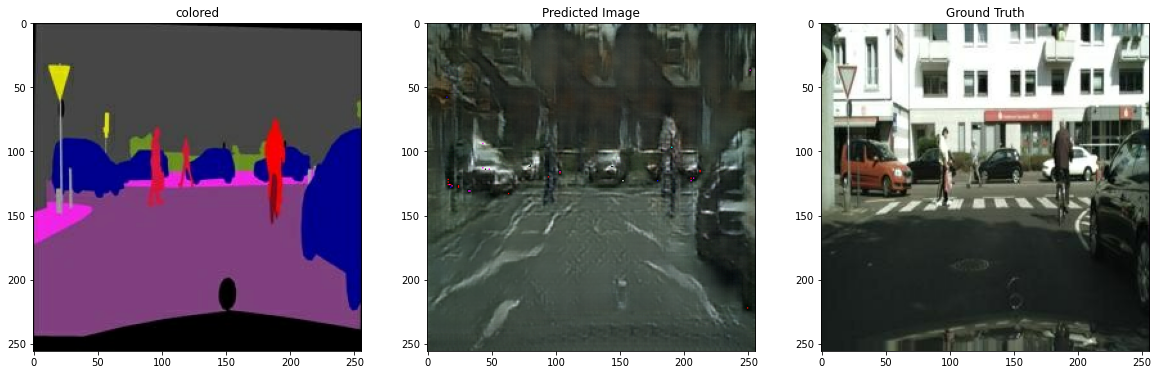

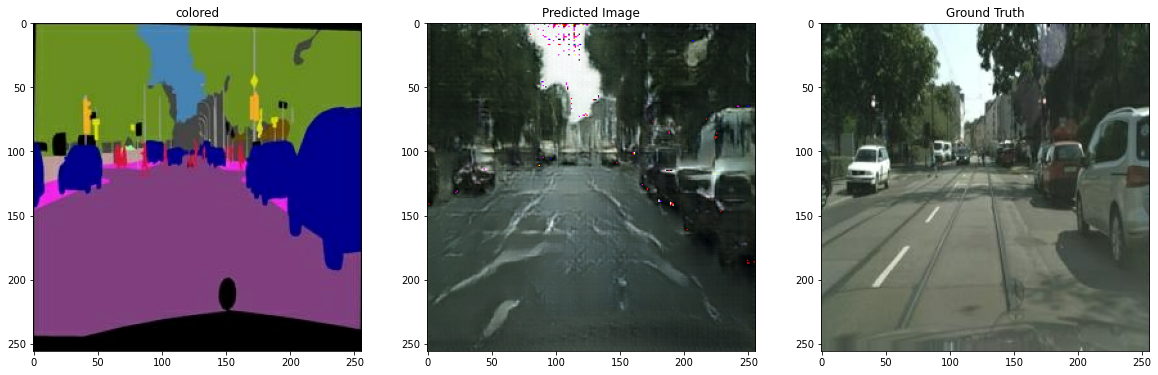

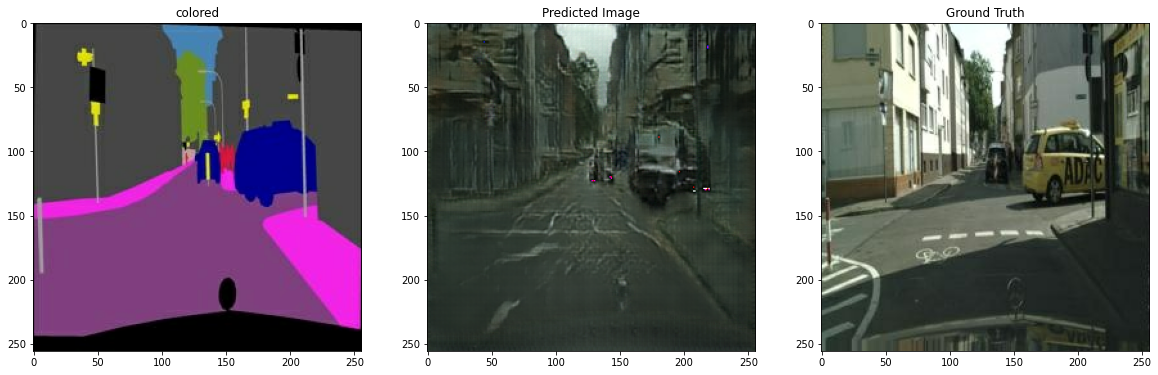

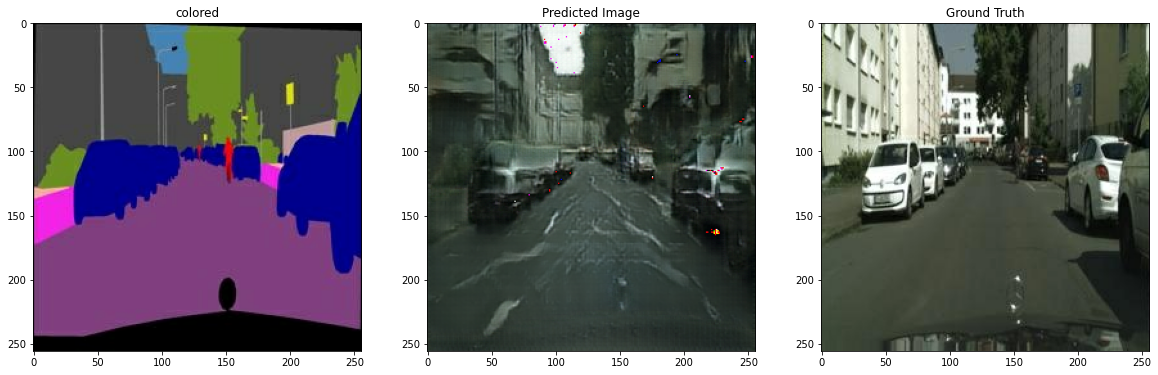

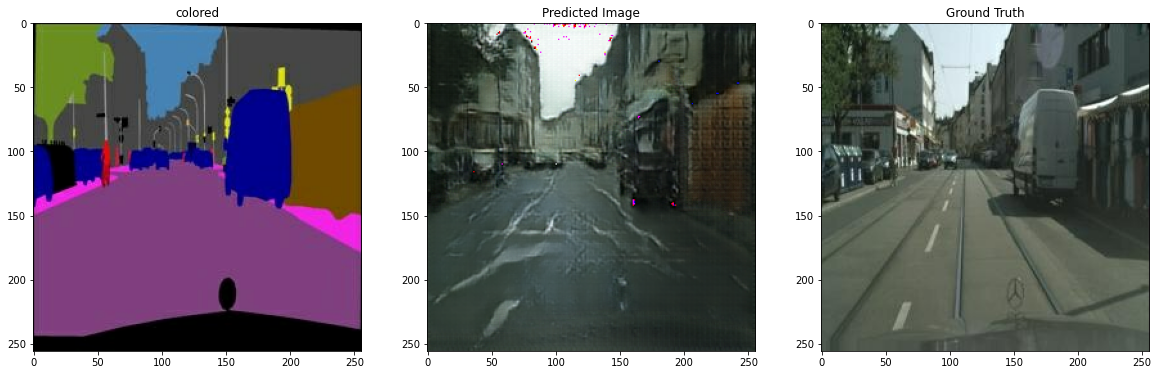

In [22]:
test_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    colored, predicted = load_img(f)

    pred = generator(tf.expand_dims(colored, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(colored)); plt.title('colored')
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image')
    plt.subplot(1,3,3); plt.imshow(denormalize(predicted)); plt.title('Ground Truth')

---

## 루브릭 관련 고려한 점

**1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.**

- 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.

**2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.**

- U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.

**3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.**

- 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

## 회고
1️⃣ 잘한 점:

- 에폭을 많이 돌려봤다.(100에폭)
- 그래도 아직 남아있는 부자연스러운 픽셀이 아쉽다.

2️⃣ 어려웠던 점:

- 문제를 반대로 생각해서 실제 이미지를 넣었을때 색칠된 이미지를 뽑는줄 알았다.
- 첨부터 하나하나 다시 코드를 살필 수 있는 기회가 되었다.

3️⃣ 느낀 점:

- Ground Truth란 단어를 처음 봤는데 다음부터 요긴하게 써야겠다.
- 마지막 EXPLORATION라 아쉽기도 하고 그간 부족한 점이 많았는데 앞으로 시작하는 GoingDeeper는 더 열심히 힘내야겠다.